In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path
from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# Independent and principal component analysis of the pulse data

Test alternative methods to analyze the two pulse intensity
- PCA / SVD
- ICA

and compare them to the current SVD method.


From sklearn:

Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the __Fast ICA__ algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals.

In [3]:
res_path = Path('/reg/d/psdm/sxr/sxrx30416/results/espov/')

from scipy.signal import savgol_filter

def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)

def filt(waveform, method='savgol', **kwargs):
    if method is 'savgol':
        if 'window_length' in kwargs:
            window_length= kwargs.pop('window_length')
        else:
            window_length = 15
        if 'polyorder' in kwargs:
            polyorder = kwargs.pop('polyorder')
        else:
            polyorder = 3
        return savgol_filter(waveform, window_length, polyorder)
    elif method is 'fft':
        if 'threshold' in kwargs:
            threshold = kwargs.pop('threshold')
        else:
            threshold = 1000
        ft = np.fft.rfft(waveform)
        ft[threshold:] = 0
        return np.fft.irfft(ft)

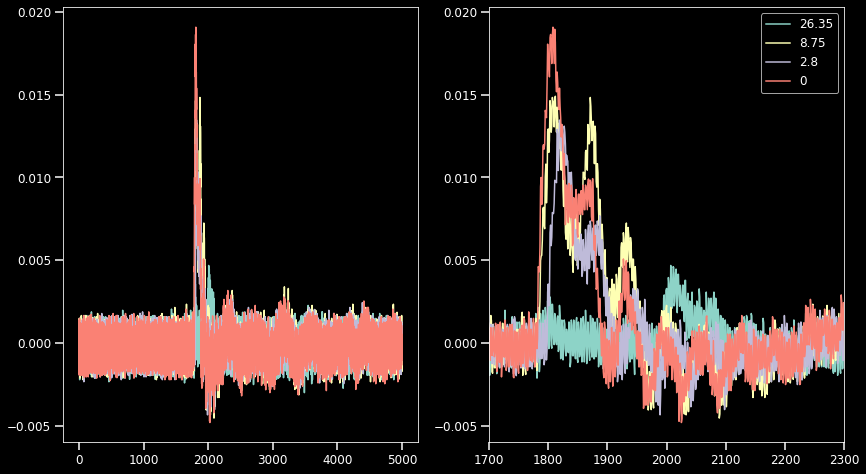

In [4]:
runs = [12,10,11,8] # 26.35 ns, 8.75 ns, 2.8 ns, 0 ns
dl = [26.35, 8.75, 2.8, 0] # ns
dat = []
n_waveforms = 5000

plt.figure(figsize=(14,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for ii, run in enumerate(runs):
#     fname = res_path / 'MCP_data' / 'MCP_r{}_small.h5'.format(run)
    fname = res_path / 'MCP_data' / 'run{}_MCP.h5'.format(run)
    with h5.File(fname, 'r') as f:
#         dat.append(np.asarray(f['MCP']))
        dat.append(np.asarray(f['waveform'][:n_waveforms]))
    
    sig = dat[ii][0]
    ax1.plot(sig)
    sig = dat[ii][0]
    ax2.plot(sig, label=str(dl[ii]))

ax2.set_xlim(1700,2300)
plt.legend()
plt.show()

## Remove background and smooth data

In [5]:
dat = [removeBackground(d) for d in dat]
dat = [filt(d, window_length=15) for d in dat]

inds = [1500,2600]
dat = [d[:,inds[0]:inds[1]] for d in dat]

26.35
(5000, 1100)


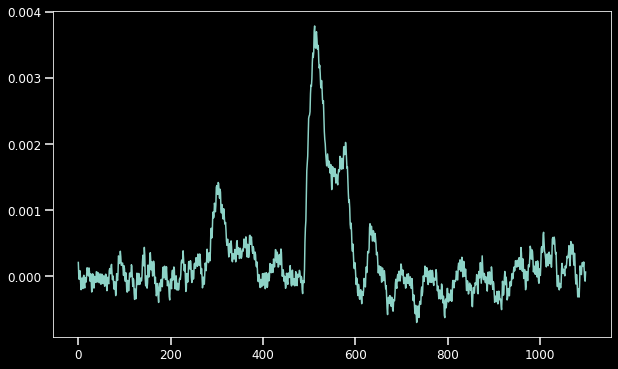

In [30]:
rii = 0
print(dl[rii])
data = dat[rii]
print(data.shape)
plt.plot(data[0])
plt.show()

# PCA

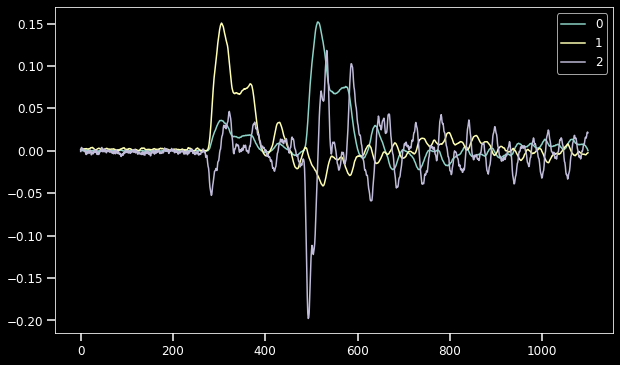

In [60]:
from sklearn.decomposition import PCA
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(data[:400,:])

for ii in range(n_components):
    plt.plot(pca.components_[ii,:], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()

[[-0.00155525  0.01277526]]


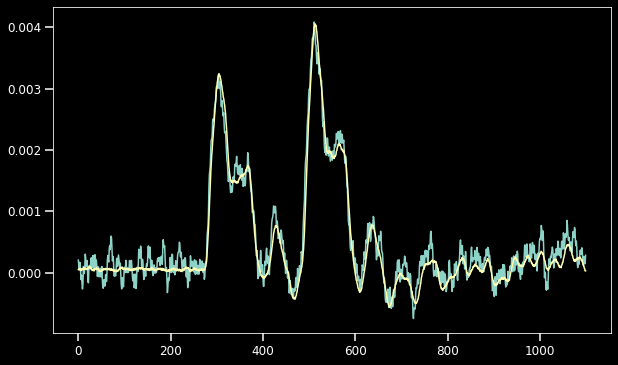

7513.805781962251


In [32]:
wave = data[215]
coeffs = pca.transform(wave.reshape(1,-1))
print(coeffs)
fit = pca.inverse_transform(coeffs)
plt.plot(wave)
plt.plot(fit.T)
plt.show()
# plt.xlim(4500,5500)

print(pca.score(data[:100]))

In [33]:
coeffs = pca.transform(data)
coeffs.shape

(5000, 2)

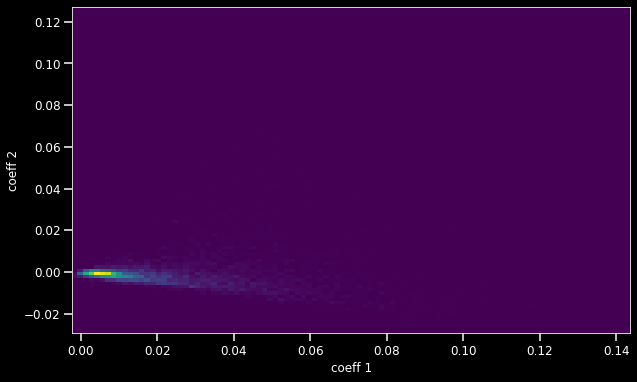

In [66]:
plt.hist2d(coeffs[:,0], coeffs[:,1], bins=100)
plt.xlabel('coeff 1')
plt.ylabel('coeff 2')
plt.show()

# ICA

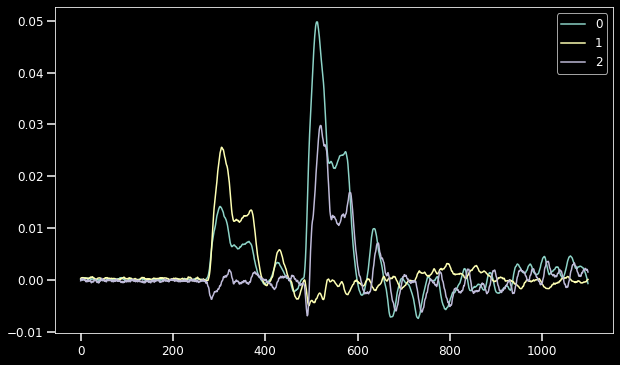

In [61]:
from sklearn.decomposition import FastICA
n_components = 3
ica = FastICA(n_components=n_components)
ica.fit(data[:400,:])

for ii in range(n_components):
    plt.plot(ica.mixing_[:,ii], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()

[[ 0.01941346  0.06015626 -0.05257121]]


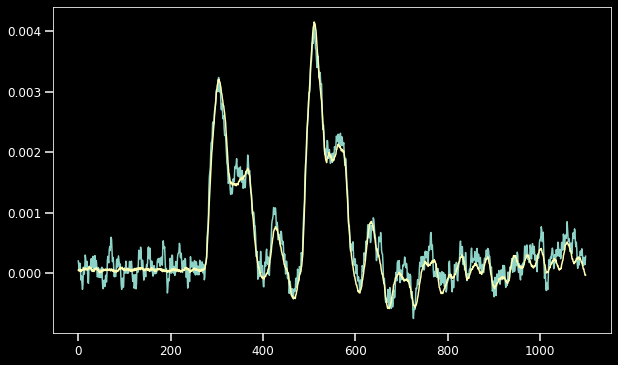

In [62]:
wave = data[215]
coeffs = ica.transform(wave.reshape(1,-1))
print(coeffs)
fit = ica.inverse_transform(coeffs)
plt.plot(wave)
plt.plot(fit.T)
plt.show()
# plt.xlim(4500,5500)

In [37]:
coeffs = ica.transform(data)
coeffs.shape

(5000, 2)

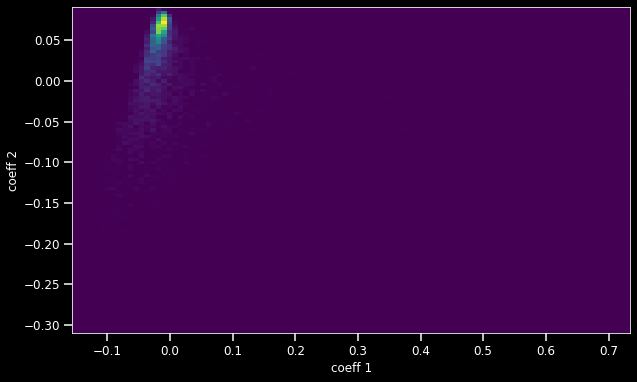

In [38]:
plt.hist2d(coeffs[:,0], coeffs[:,1], bins=100)
plt.xlabel('coeff 1')
plt.ylabel('coeff 2')
plt.show()

## SVD

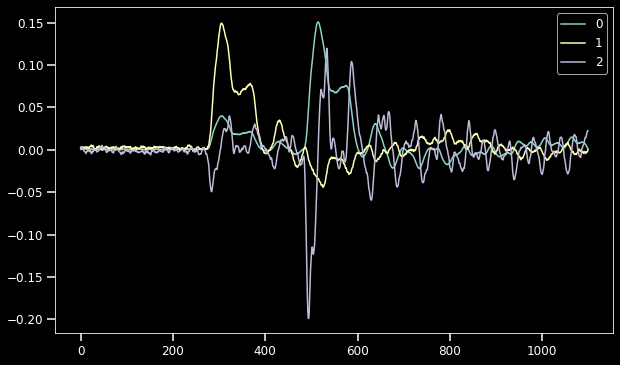

In [63]:
from sklearn.decomposition import TruncatedSVD
n_components = 3
svd = TruncatedSVD(n_components=n_components)
svd.fit(data[:200,:])

for ii in range(n_components):
    plt.plot(svd.components_[ii,:], label=str(ii))
# plt.xlim(4500,5500)
plt.legend()
plt.show()

In [64]:
coeffs = svd.transform(data)
coeffs.shape

(5000, 3)

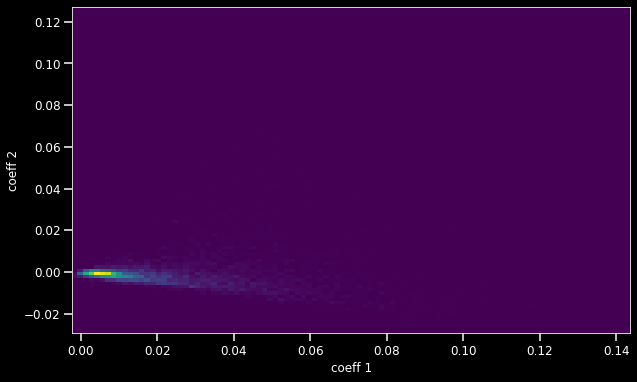

In [65]:
plt.hist2d(coeffs[:,0], coeffs[:,1], bins=100)
plt.xlabel('coeff 1')
plt.ylabel('coeff 2')
plt.show()

SVD is the same as PCA.

All methods fit pretty well the data using only two components. The main issue is that the extraction of the single pulse intensity is not straightforward, as the components often still contain a mixture of the two pulses.

# Get the single-pulse intensities from the PCA/ICA/SVD fit

Idea: calculate the mixing matrix for the pca/svd/ica basis and the two-pulse basis and get the two-pulse intensity by converting the pca/svd/ica coefficients into the two-pulse basis. The problem is that the different basis may not span exactly the same subpsace. That would be a significant problem 

Would that be better than directly fitting the two-pulse basis? I think it might be. Because the mixing matrix will be computed based in many waveforms, it should be pretty reliable. Then, the fit of with pca/svd/ica of the waveform should be more reliable than the fit of the two pulse basis, which is artificially build from single pulse traces.


To do:
- Check that ICA, and SVD basis map the same subspace as the two pulse SVD basis
- 

In [150]:
singlePulseData = dat[3]
n_ = 1
regr2 = proc.construct_waveformRegressor(singlePulseData[:150], 
                                         n_components=n_, 
                                         method='pinv',
                                         mode='double', 
                                         delay=dl[2])
A = regr2.A
proj = regr2.projector

## Test

[0.02940551 0.07029212]


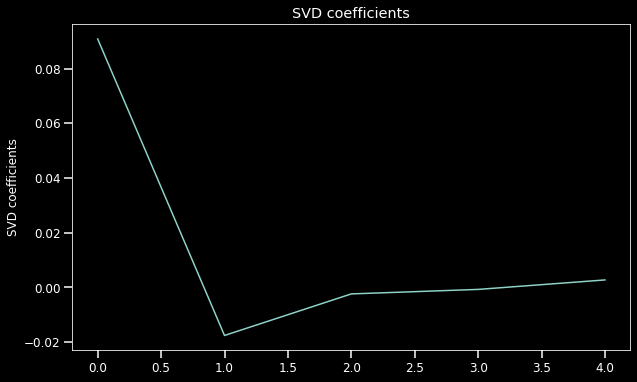

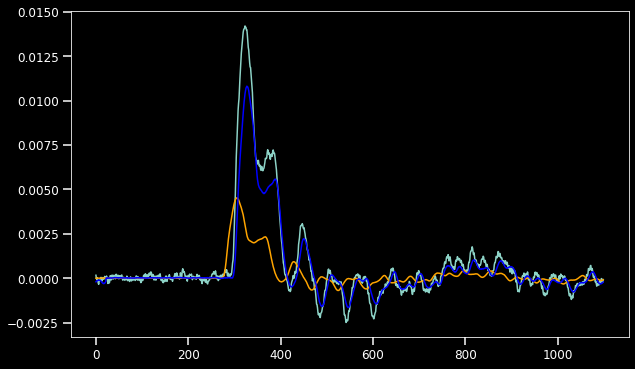

In [167]:
rii = 2
n_components = 5
data = dat[rii]
svd = TruncatedSVD(n_components=n_components)
# svd = PCA(n_components=n_components)
svd.fit(data[:400,:])
coeffs = svd.transform(data)
mixing = A.dot(svd.components_.T)

ii = 21
# print(coeffs[ii])
plt.figure()
plt.title('SVD coefficients')
plt.plot(coeffs[ii])
plt.ylabel('SVD coefficients')
coeffs_twoPulse = np.linalg.pinv(mixing).T.dot(coeffs[ii])
print(coeffs_twoPulse)
reconstructed = coeffs_twoPulse.T.dot(A)
pulse1 = coeffs_twoPulse[0]*A[0,:]
pulse2 = coeffs_twoPulse[1]*A[1,:]

plt.figure()
plt.plot(data[ii])
# plt.plot(reconstructed)
plt.plot(pulse1, 'orange')
plt.plot(pulse2,'b')
# plt.plot(svd.inverse_transform(coeffs[ii].reshape(1,-1)))
plt.show()

IT WORKS!

In [ ]:
rii = 2
data = dat[rii]
plt.figure(figsize=(14,8))
for ii in range(6):
    ind = np.random.randint(data.shape[0])
    coeffs_twoPulse = np.linalg.pinv(mixing).T.dot(coeffs[ii])
    reconstructed = coeffs_twoPulse.T.dot(A)
    pulse1 = coeffs_twoPulse[0]*A[0,:]
    pulse2 = coeffs_twoPulse[1]*A[1,:]
    
    ax = plt.subplot(2,3,ii+1)
    ax.set_title('{}'.format(ind))
    ax.plot(data[ind])
    ax.plot(pulse1, 'orange')
    ax.plot(pulse2,'b')
    
    print(ind)

1909
4840
1270
2014
4827
4929


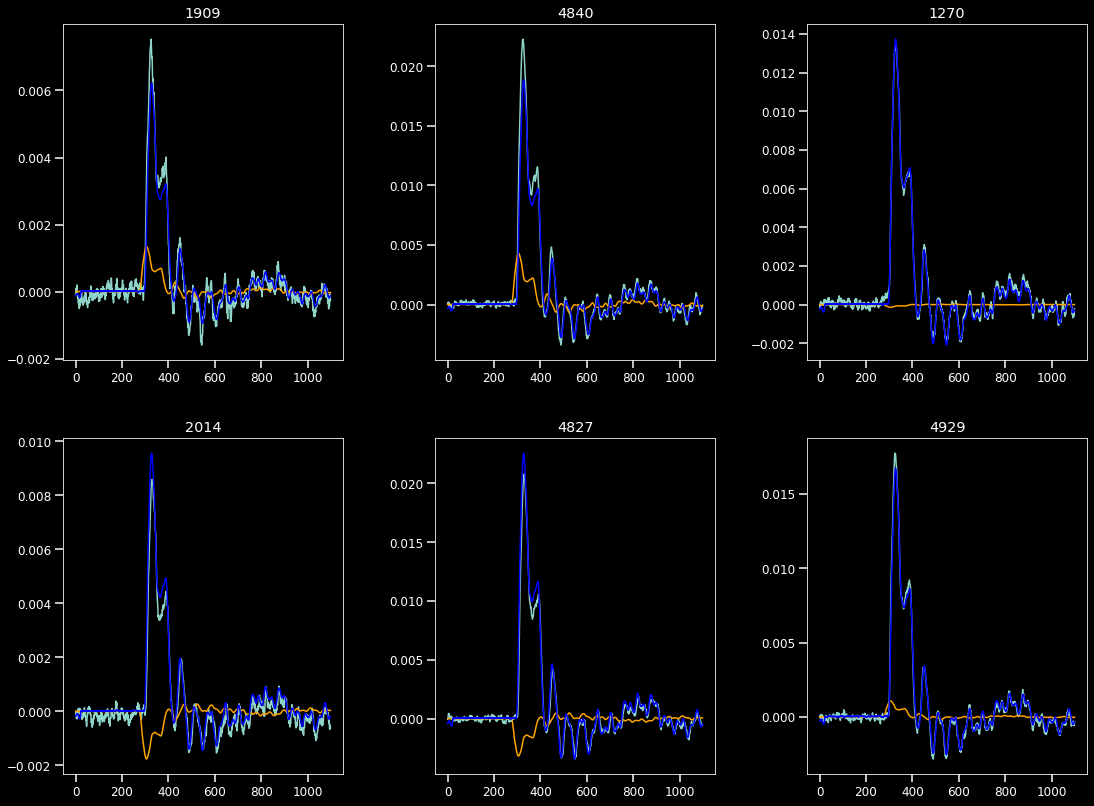

In [176]:
rii = 2
data = dat[rii]
plt.figure(figsize=(16,12))
for ii in range(6):
    ind = np.random.randint(data.shape[0])
    coeffs_twoPulse = np.linalg.pinv(mixing).T.dot(coeffs[ind])
    reconstructed = coeffs_twoPulse.T.dot(A)
    pulse1 = coeffs_twoPulse[0]*A[0,:]
    pulse2 = coeffs_twoPulse[1]*A[1,:]
    
    ax = plt.subplot(2,3,ii+1)
    ax.set_title('{}'.format(ind))
    ax.plot(data[ind])
    ax.plot(pulse1, 'orange')
    ax.plot(pulse2,'b')
    
    print(ind)
plt.tight_layout(pad=3)

[ 0.0409354   0.00166519 -0.00224075 -0.00214745  0.00011994]


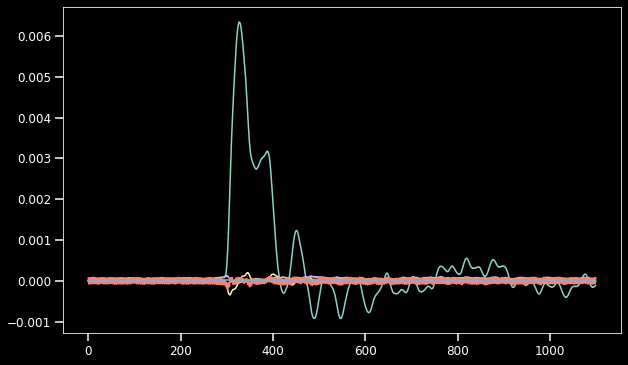

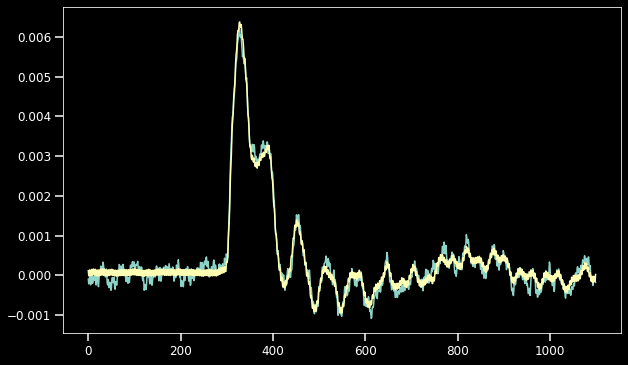

In [147]:
ii = 8
cs = coeffs[ii]
d = data[ii]
comps = svd.components_

print(cs)

for c, comp in zip(cs,comps):
    plt.plot(c*comp)
# plt.plot(svd.inverse_transform(cs.reshape(1,-1)))
fig, ax = plt.subplots()
ax.plot(d)
ax.plot(svd.inverse_transform(cs.reshape(1,-1)).T)
plt.show()

In [15]:
a= np.random.rand(2,3)
b= np.random.rand(2,3)
c = [a,b]